In [1]:
import timeit
import logging
from tqdm import tqdm
import arviz as az
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import pytensor as pyt
from random import randint
from prophet import Prophet
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import yfinance
from abc import ABC, abstractmethod

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

Importing plotly failed. Interactive plots will not work.


# Model

In [2]:
def get_group_definition(X, pool_cols, pool_type):
    if pool_type == "complete":
        group = np.zeros(len(X), dtype="int")
        group_mapping = {0: "all"}
        n_groups = 1
    else:
        X[pool_cols] = pd.Categorical(X[pool_cols])
        group = X[pool_cols].cat.codes.values
        group_mapping = dict(enumerate(X[pool_cols].cat.categories))
        n_groups = X[pool_cols].nunique()
    return group, n_groups, group_mapping


class TimeSeriesModel:
    def _scale_data(self):
        self.y_min = 0
        self.y_max = self.data["y"].abs().max()
        self.ds_min = self.data["ds"].min()
        self.ds_max = self.data["ds"].max()

        self.data["y"] = self.data["y"] / self.y_max
        self.data["t"] = (self.data["ds"] - self.ds_min) / (self.ds_max - self.ds_min)

    def _process_data(self):
        self.data["ds"] = pd.to_datetime(self.data["ds"])
        self.data.sort_values("ds", inplace=True)
        self._scale_data()

    def _model_init(self):
        i0, i1 = self.data["ds"].idxmin(), self.data["ds"].idxmax()
        T = self.data["t"].iloc[i1] - self.data["t"].iloc[i0]
        slope = (self.data["y"].iloc[i1] - self.data["y"].iloc[i0]) / T
        intercept = self.data["y"].iloc[i0] - slope * self.data["t"].iloc[i0]
        return {
            "slope": slope,
            "intercept": intercept,
            "delta": 0.0,
            "beta": 0.0,
            "sigma": 1.0,
        }

    def fit(
        self,
        data,
        sigma_sd=0.5,
        mcmc_samples=0,
        chains=4,
        cores=4,
        use_prophet_initvals=True,
    ):
        self.mcmc_samples = mcmc_samples

        self.data = data.reset_index(drop=True)
        self._process_data()

        self.initvals = {}
        # if use_prophet_initvals:
        #     self.initvals = self._model_init()

        self.model = pm.Model()
        self.model_idxs = {}
        mu = self.definition(self.model, self.data, self.initvals, self.model_idxs)

        with self.model:
            sigma = pm.HalfNormal(
                "sigma", sigma_sd, initval=self.initvals.get("sigma", 1)
            )
            obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=self.data["y"])

            self.map_approx = None
            self.trace = None
            if self.mcmc_samples == 0:
                self.map_approx = pm.find_MAP(progressbar=True, maxeval=1e4)
            else:
                self.trace = pm.sample(self.mcmc_samples, chains=chains, cores=cores)

    def _make_future_df(self, days):
        future = pd.DataFrame(
            {
                "ds": pd.DatetimeIndex(
                    np.hstack(
                        (
                            self.data["ds"].unique().to_numpy(),
                            pd.date_range(
                                self.ds_max,
                                self.ds_max + pd.Timedelta(days, "D"),
                                inclusive="right",
                            ).to_numpy(),
                        )
                    )
                )
            }
        )
        future["t"] = (future["ds"] - self.ds_min) / (self.ds_max - self.ds_min)
        return future

    def predict(self, days):
        future = self._make_future_df(days)
        forecasts = self._predict(
            future, self.mcmc_samples, self.map_approx, self.trace
        )

        for group_code in range(forecasts.shape[0]):
            future[f"yhat_{group_code}"] = forecasts[group_code] * self.y_max
            for model_type, model_cnt in self.model_idxs.items():
                if model_type.startswith("fs"):
                    continue
                for model_idx in range(model_cnt):
                    future[f"{model_type}_{model_idx}_{group_code}"] *= self.y_max

        return future

    def _predict(self, future, mcmc_samples, map_approx, trace):
        if mcmc_samples == 0:
            return self._predict_map(future, map_approx)

        return self._predict_mcmc(future, trace)

    def plot(self, future, y_true=None, pool_cols=None):
        plt.figure(figsize=(14, 100 * 6))
        plt.subplot(100, 1, 1)
        plt.title("Predictions")
        plt.grid()

        group, n_groups, groups_ = get_group_definition(
            self.data, pool_cols, "not_complete"
        )
        for group_code, group_name in groups_.items():
            group_idx = group == group_code
            color = np.random.rand(3)
            plt.scatter(
                self.data["ds"][group_idx],
                self.data["y"][group_idx] * self.y_max,
                s=0.5,
                color=color,
                label=group_name,
            )

        if y_true is not None:
            test_group, test_n_groups, test_groups_ = get_group_definition(
                y_true, pool_cols, "not_complete"
            )
            for group_code, group_name in test_groups_.items():
                group_idx = test_group == group_code
                color = np.random.rand(3)
                plt.scatter(
                    y_true["ds"][group_idx],
                    y_true["y"][group_idx],
                    s=0.5,
                    color=color,
                    label=f"y - {group_name}",
                )

        for group_code, group_name in groups_.items():
            plt.plot(
                future["ds"],
                future[f"yhat_{group_code}"],
                lw=1,
                label=f"yhat - {group_name}",
            )

        plt.legend()
        plot_params = {"idx": 1}
        self._plot(plot_params, future, self.data, self.y_max, y_true)

    def metrics(self, y_true, future, pool_cols=None):
        metrics = {}
        test_group, test_n_groups, test_groups_ = get_group_definition(
            y_true, pool_cols, "not_complete"
        )
        for group_code, group_name in test_groups_.items():
            metrics[group_name] = {}
            group_idx = test_group == group_code
            y = y_true["y"][group_idx]
            yhat = future[f"yhat_{group_code}"][-len(y) :]
            metrics[group_name]["mse"] = mean_squared_error(y, yhat)
            metrics[group_name]["rmse"] = root_mean_squared_error(y, yhat)
            metrics[group_name]["mae"] = mean_absolute_error(y, yhat)
            metrics[group_name]["mape"] = mean_absolute_percentage_error(y, yhat)

        return pd.DataFrame(metrics)

    def __add__(self, other):
        return AdditiveTimeSeries(self, other)

    def __mul__(self, other):
        return MultiplicativeTimeSeries(self, other)


class AdditiveTimeSeries(TimeSeriesModel):
    def __init__(self, left, right):
        self.left = left
        self.right = right

    def definition(self, *args, **kwargs):
        return self.left.definition(*args, **kwargs) + self.right.definition(
            *args, **kwargs
        )

    def _predict(self, *args, **kwargs):
        return self.left._predict(*args, **kwargs) + self.right._predict(
            *args, **kwargs
        )

    def _plot(self, *args, **kwargs):
        self.left._plot(*args, **kwargs)
        self.right._plot(*args, **kwargs)


class MultiplicativeTimeSeries(TimeSeriesModel):
    def __init__(self, left, right):
        self.left = left
        self.right = right

    def definition(self, *args, **kwargs):
        return self.left.definition(*args, **kwargs) * (
            1 + self.right.definition(*args, **kwargs)
        )

    def _predict(self, *args, **kwargs):
        return self.left._predict(*args, **kwargs) * (
            1 + self.right._predict(*args, **kwargs)
        )

    def _plot(self, *args, **kwargs):
        self.left._plot(*args, **kwargs)
        self.right._plot(*args, **kwargs)


class LinearTrend(TimeSeriesModel):
    def __init__(
        self,
        n_changepoints=25,
        changepoint_range=0.8,
        slope_mean=0,
        slope_sd=5,
        intercept_mean=0,
        intercept_sd=5,
        delta_mean=0,
        delta_sd=0.05,
        pool_cols=None,
        pool_type="complete",
    ):
        self.n_changepoints = n_changepoints
        self.changepoint_range = changepoint_range
        self.slope_mean = slope_mean
        self.slope_sd = slope_sd
        self.intercept_mean = intercept_mean
        self.intercept_sd = intercept_sd
        self.delta_mean = delta_mean
        self.delta_sd = delta_sd

        self.pool_cols = pool_cols
        self.pool_type = pool_type

    def definition(self, model, data, initvals, model_idxs):
        model_idxs["lt"] = model_idxs.get("lt", 0)
        self.model_idx = model_idxs["lt"]
        model_idxs["lt"] += 1

        group, n_groups, self.groups_ = get_group_definition(
            data, self.pool_cols, self.pool_type
        )

        t = np.array(data["t"])
        hist_size = int(np.floor(data.shape[0] * self.changepoint_range))
        cp_indexes = (
            np.linspace(0, hist_size - 1, self.n_changepoints + 1).round().astype(int)
        )
        self.s = np.array(data.iloc[cp_indexes]["t"].tail(-1))

        # * 1 casts the boolean to integers
        A = (t[:, None] > self.s) * 1

        with model:
            if self.pool_type == "partial":
                sigma_slope = pm.HalfCauchy(
                    f"lt_{self.model_idx} - sigma_slope", beta=self.slope_sd
                )
                offset_slope = pm.Normal(
                    f"lt_{self.model_idx} - offset_slope", mu=0, sigma=1, shape=n_groups
                )
                slope = pm.Deterministic(
                    f"lt_{self.model_idx} - slope", offset_slope * sigma_slope
                )

                delta_sd = self.delta_sd
                if self.delta_sd is None:
                    delta_sd = pm.Exponential(f"lt_{self.model_idx} - tau", 1.5)

                sigma_delta = pm.HalfCauchy(
                    f"lt_{self.model_idx} - sigma_delta", beta=delta_sd
                )
                offset_delta = pm.Laplace(
                    f"lt_{self.model_idx} - offset_delta",
                    0,
                    1,
                    shape=(n_groups, self.n_changepoints),
                )
                delta = pm.Deterministic(
                    f"lt_{self.model_idx} - delta", offset_delta * sigma_delta
                )
            else:
                slope = pm.Normal(
                    f"lt_{self.model_idx} - slope",
                    self.slope_mean,
                    self.slope_sd,
                    initval=initvals.get("slope", None),
                    shape=n_groups,
                )

                delta_sd = self.delta_sd
                if self.delta_sd is None:
                    delta_sd = pm.Exponential(f"lt_{self.model_idx} - tau", 1.5)

                delta = pm.Laplace(
                    f"lt_{self.model_idx} - delta",
                    self.delta_mean,
                    delta_sd,
                    shape=(n_groups, self.n_changepoints),
                )

            intercept = pm.Normal(
                f"lt_{self.model_idx} - intercept",
                self.intercept_mean,
                self.intercept_sd,
                initval=initvals.get("intercept", None),
                shape=n_groups,
            )

            gamma = -self.s * delta[group, :]

            trend = pm.Deterministic(
                f"lt_{self.model_idx} - trend",
                (slope[group] + pm.math.sum(A * delta[group], axis=1)) * t
                + (intercept[group] + pm.math.sum(A * gamma, axis=1)),
            )

        return trend

    def _predict_map(self, future, map_approx):
        forecasts = []
        new_A = (np.array(future["t"])[:, None] > self.s) * 1

        for group_code in self.groups_.keys():
            forecasts.append(
                np.array(
                    (
                        map_approx[f"lt_{self.model_idx} - slope"][group_code]
                        + np.dot(
                            new_A,
                            map_approx[f"lt_{self.model_idx} - delta"][group_code],
                        )
                    )
                    * future["t"]
                    + (
                        map_approx[f"lt_{self.model_idx} - intercept"][group_code]
                        + np.dot(
                            new_A,
                            (
                                -self.s
                                * map_approx[f"lt_{self.model_idx} - delta"][group_code]
                            ),
                        )
                    )
                )
            )
            future[f"lt_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _predict_mcmc(self, future, trace):
        forecasts = []
        new_A = (np.array(future["t"])[:, None] > self.s) * 1

        for group_code in self.groups_.keys():
            delta = (
                trace["posterior"][f"lt_{self.model_idx} - delta"]
                .to_numpy()[:, :, group_code]
                .mean(0)
            )
            slope = (
                trace["posterior"][f"lt_{self.model_idx} - slope"]
                .to_numpy()[:, :, group_code]
                .mean(0)
            )
            intercept = (
                trace["posterior"][f"lt_{self.model_idx} - intercept"]
                .to_numpy()[:, :, group_code]
                .mean(0)
            )

            forecasts.append(
                (
                    (slope + np.dot(new_A, delta.T)).T * future["t"].to_numpy()
                    + (intercept + np.dot(new_A, (-self.s * delta).T)).T
                ).mean(0)
            )
            future[f"lt_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _plot(self, plot_params, future, data, y_max, y_true=None):
        plot_params["idx"] += 1
        plt.subplot(100, 1, plot_params["idx"])
        plt.title(f"lt_{self.model_idx}")
        plt.grid()

        for group_code, group_name in self.groups_.items():
            plt.plot(
                future["ds"],
                future[f"lt_{self.model_idx}_{group_code}"],
                lw=1,
                label=group_name,
            )

        plt.legend()


class FourierSeasonality(TimeSeriesModel):
    def __init__(
        self,
        period,
        series_order,
        beta_mean=0,
        beta_sd=10,
        shrinkage_strength=100,
        pool_cols=None,
        pool_type="complete",
    ):
        self.period = period
        self.series_order = series_order
        self.beta_mean = beta_mean
        self.beta_sd = beta_sd
        self.shrinkage_strength = shrinkage_strength

        self.pool_cols = pool_cols
        self.pool_type = pool_type

    def _fourier_series(self, data):
        # convert to days since epoch
        NANOSECONDS_TO_SECONDS = 1000 * 1000 * 1000
        t = (
            data["ds"].to_numpy(dtype=np.int64)
            // NANOSECONDS_TO_SECONDS
            / (3600 * 24.0)
        )

        x_T = t * np.pi * 2
        fourier_components = np.empty((data["ds"].shape[0], 2 * self.series_order))
        for i in range(self.series_order):
            c = x_T * (i + 1) / self.period
            fourier_components[:, 2 * i] = np.sin(c)
            fourier_components[:, (2 * i) + 1] = np.cos(c)

        return fourier_components

    def definition(self, model, data, initvals, model_idxs):
        model_idxs["fs"] = model_idxs.get("fs", 0)
        self.model_idx = model_idxs["fs"]
        model_idxs["fs"] += 1

        group, n_groups, self.groups_ = get_group_definition(
            data, self.pool_cols, self.pool_type
        )

        x = self._fourier_series(data)
        beta_initval = initvals.get("beta", None)
        if beta_initval is not None:
            beta_initval = np.array([beta_initval] * 2 * self.series_order)

        with model:
            if self.pool_type == "partial":
                mu_beta = pm.Normal(
                    f"fs_{self.model_idx} - beta_mu(p={self.period},n={self.series_order})",
                    mu=self.beta_mean,
                    sigma=self.beta_sd,
                    shape=2 * self.series_order,
                    initval=beta_initval,
                )
                sigma_beta = pm.HalfNormal(
                    f"fs_{self.model_idx} - beta_sigma(p={self.period},n={self.series_order})",
                    sigma=self.beta_sd / self.shrinkage_strength,
                    shape=2 * self.series_order,
                )
                offset_beta = pm.Normal(
                    f"fs_{self.model_idx} - offset_beta(p={self.period},n={self.series_order})",
                    mu=0,
                    sigma=1,
                    shape=(n_groups, 2 * self.series_order),
                )

                beta = pm.Deterministic(
                    f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})",
                    mu_beta + offset_beta * sigma_beta,
                )
            else:
                beta = pm.Normal(
                    f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})",
                    mu=self.beta_mean,
                    sigma=self.beta_sd,
                    shape=(n_groups, 2 * self.series_order),
                    initval=beta_initval,
                )

        return pm.math.sum(x * beta[group], axis=1)

    def _det_seasonality_posterior(self, beta, x):
        return np.dot(x, beta.T)

    def _predict_map(self, future, map_approx):
        forecasts = []
        for group_code in self.groups_.keys():
            forecasts.append(
                self._det_seasonality_posterior(
                    map_approx[
                        f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})"
                    ][group_code],
                    self._fourier_series(future),
                )
            )
            future[f"fs_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _predict_mcmc(self, future, trace):
        forecasts = []
        for group_code in self.groups_.keys():
            forecasts.append(
                self._det_seasonality_posterior(
                    trace["posterior"][
                        f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})"
                    ]
                    .to_numpy()[:, :, group_code]
                    .mean(0),
                    self._fourier_series(future),
                ).T.mean(0)
            )
            future[f"fs_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _plot(self, plot_params, future, data, y_max, y_true=None):
        date = future["ds"] if self.period > 7 else future["ds"].dt.day_name()
        plot_params["idx"] += 1
        plt.subplot(100, 1, plot_params["idx"])
        plt.title(f"fs_{self.model_idx} - p={self.period},n={self.series_order}")
        plt.grid()

        for group_code, group_name in self.groups_.items():
            plt.plot(
                date[-int(self.period) :],
                future[f"fs_{self.model_idx}_{group_code}"][-int(self.period) :],
                lw=1,
                label=group_name,
            )

        plt.legend()


class Constant(TimeSeriesModel):
    def __init__(self, lower, upper, pool_cols=None, pool_type="complete"):
        self.lower = lower
        self.upper = upper
        self.pool_cols = pool_cols
        self.pool_type = pool_type

    def definition(self, model, data, initvals, model_idxs):
        model_idxs["c"] = model_idxs.get("c", 0)
        self.model_idx = model_idxs["c"]
        model_idxs["c"] += 1

        group, n_groups, self.groups_ = get_group_definition(
            data, self.pool_cols, self.pool_type
        )

        with model:
            if self.pool_type == "partial":
                mu_c = pm.Uniform(
                    f"c_{self.model_idx} - mu_c(l={self.lower},u={self.upper})",
                    lower=self.lower,
                    upper=self.upper,
                    shape=n_groups,
                )
                offset_c = pm.Normal(
                    f"c_{self.model_idx} - offset_c(l={self.lower},u={self.upper})",
                    mu=0,
                    sigma=1,
                    shape=n_groups,
                )
                c = pm.Deterministic(
                    f"c_{self.model_idx} - c(l={self.lower},u={self.upper})",
                    mu_c + offset_c,
                )
            else:
                c = pm.Uniform(
                    f"c_{self.model_idx} - c(l={self.lower},u={self.upper})",
                    lower=self.lower,
                    upper=self.upper,
                    shape=n_groups,
                )

        return c[group]

    def _predict_map(self, future, map_approx):
        forecasts = []
        for group_code in self.groups_.keys():
            forecasts.append(
                np.ones_like(future["t"])
                * map_approx[f"c_{self.model_idx} - c(l={self.lower},u={self.upper})"][
                    group_code
                ]
            )
            future[f"c_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _predict_mcmc(self, future, trace):
        forecasts = []
        for group_code in self.groups_.keys():
            forecasts.append(
                np.ones_like(future["t"])
                * trace["posterior"][
                    f"c_{self.model_idx} - c(l={self.lower},u={self.upper})"
                ]
                .to_numpy()[:, :, group_code]
                .mean()
            )
            future[f"c_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _plot(self, plot_params, future, data, y_max, y_true=None):
        plot_params["idx"] += 1
        plt.subplot(100, 1, plot_params["idx"])
        plt.title(f"c_{self.model_idx} - c(l={self.lower},u={self.upper})")

        plot_data = []
        for group_code, group_name in self.groups_.items():
            plot_data.append(
                (group_name, future[f"c_{self.model_idx}_{group_code}"][0])
            )

        plt.bar(*zip(*plot_data))
        plt.axhline(0, c="k", linewidth=3)

# Fetch data

In [2]:
data = yfinance.download(
    ["^GSPC", "MSFT", "AAPL", "GOOG"],
    interval="1d",
    start="2000-01-01",
    end="2020-01-01",
)
data

[*********************100%***********************]  4 of 4 completed


Price       Adj Close                                          Close  \
Ticker           AAPL       GOOG        MSFT        ^GSPC       AAPL   
Date                                                                   
2000-01-03   0.843077        NaN   35.864063  1455.219971   0.999442   
2000-01-04   0.771997        NaN   34.652584  1399.420044   0.915179   
2000-01-05   0.783293        NaN   35.017944  1402.109985   0.928571   
2000-01-06   0.715509        NaN   33.844917  1403.449951   0.848214   
2000-01-07   0.749402        NaN   34.287209  1441.469971   0.888393   
...               ...        ...         ...          ...        ...   
2019-12-24  68.898705  66.937485  150.531693  3223.379883  71.067497   
2019-12-26  70.265663  67.776466  151.765533  3239.909912  72.477501   
2019-12-27  70.238991  67.352501  152.042908  3240.020020  72.449997   
2019-12-30  70.655884  66.567810  150.732544  3221.290039  72.879997   
2019-12-31  71.172134  66.611656  150.837753  3230.780029  73.412498   

Price                                                High             ...  \
Ticker           GOOG        MSFT        ^GSPC       AAPL       GOOG  ...   
Date                                                                  ...   
2000-01-03        NaN   58.281250  1455.219971   1.004464        NaN  ...   
2000-01-04        NaN   56.312500  1399.420044   0.987723        NaN  ...   
2000-01-05        NaN   56.906250  1402.109985   0.987165        NaN  ...   
2000-01-06        NaN   55.000000  1403.449951   0.955357        NaN  ...   
2000-01-07        NaN   55.718750  1441.469971   0.901786        NaN  ...   
...               ...         ...          ...        ...        ...  ...   
2019-12-24  67.178001  157.380005  3223.379883  71.222504  67.513000  ...   
2019-12-26  68.019997  158.669998  3239.909912  72.495003  68.066353  ...   
2019-12-27  67.594498  158.960007  3240.020020  73.492500  68.226501  ...   
2019-12-30  66.806999  157.589996  3221.290039  73.172501  67.650002  ...   
2019-12-31  66.850998  157.699997  3230.780029  73.419998  66.900002  ...   

Price              Low                    Open                         \
Ticker            MSFT        ^GSPC       AAPL       GOOG        MSFT   
Date                                                                    
2000-01-03   56.000000  1438.359985   0.936384        NaN   58.687500   
2000-01-04   56.125000  1397.430054   0.966518        NaN   56.781250   
2000-01-05   54.687500  1377.680054   0.926339        NaN   55.562500   
2000-01-06   54.187500  1392.099976   0.947545        NaN   56.093750   
2000-01-07   53.656250  1400.729980   0.861607        NaN   54.312500   
...                ...          ...        ...        ...         ...   
2019-12-24  157.119995  3220.510010  71.172501  67.425003  157.479996   
2019-12-26  157.399994  3227.199951  71.205002  67.308502  157.559998   
2019-12-27  158.220001  3234.370117  72.779999  68.149498  159.449997   
2019-12-30  156.729996  3216.570068  72.364998  67.500000  158.990005   
2019-12-31  156.449997  3212.030029  72.482498  66.505501  156.770004   

Price                       Volume                                    
Ticker            ^GSPC       AAPL        GOOG      MSFT       ^GSPC  
Date                                                                  
2000-01-03  1469.250000  535796800         NaN  53228400   931800000  
2000-01-04  1455.219971  512377600         NaN  54119000  1009000000  
2000-01-05  1399.420044  778321600         NaN  64059600  1085500000  
2000-01-06  1402.109985  767972800         NaN  54976600  1092300000  
2000-01-07  1403.449951  460734400         NaN  62013600  1225200000  
...                 ...        ...         ...       ...         ...  
2019-12-24  3225.449951   48478800   6950000.0   8989200  1296530000  
2019-12-26  3227.199951   93121200  13350000.0  14520600  2164540000  
2019-12-27  3247.229980  146266000  20768000.0  18412800  2429150000  
2019-12-30  3240.090088  144114400  2

In [3]:
dfs = []
for ticker in ["^GSPC", "MSFT", "GOOG", "AAPL"]:
    df = pd.DataFrame(
        data={
            "open": data["Open"][ticker].to_numpy(),
            "high": data["High"][ticker].to_numpy(),
            "low": data["Low"][ticker].to_numpy(),
            "close": data["Adj Close"][ticker].to_numpy(),
            "typical_price": ((data["Open"][ticker] + data["High"][ticker] + data["Low"][ticker] + data["Close"][ticker]) / 4).to_numpy(),
        }, 
        index=data["Adj Close"][ticker].index
    )
    
    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    df = df.reindex(full_date_range).interpolate()
    df["ds"] = df.index
    df.reset_index(drop=True, inplace=True)
    df["series"] = ticker
    dfs.append(df)

# Experiments

In [5]:
def generate_train_test_df(start, window, horizon, dfs, for_prophet=False):
    train_dfs = []
    test_dfs = []
    scales = []
    for df in dfs:
        train_df = df[start:start + window].copy()
        scales.append(train_df["typical_price"].max())
        train_df["y"] = train_df["typical_price"] / scales[-1]
        test_df = df[start + window:start + window + horizon].copy()
        test_df["y"] = test_df["typical_price"] / scales[-1]
        train_dfs.append(train_df)
        test_dfs.append(test_df)

    if for_prophet:
        return train_dfs, test_dfs, scales

    return pd.concat(train_dfs), pd.concat(test_dfs), scales

In [6]:
train_df_1, test_df_1, scales_1 = generate_train_test_df(start=0, window=365 * 18, horizon=365, dfs=[dfs[0]])
train_df_2, test_df_2, scales_2 = generate_train_test_df(start=365 * 17, window=365 * 1, horizon=365, dfs=[dfs[1]])
train_df = pd.concat((train_df_1, train_df_2))
test_df = pd.concat((test_df_1, test_df_2))
train_df

,open,high,low,close,typical_price,ds,series,y
0,1469.250000,1478.000000,1438.359985,1455.219971,1460.207489,2000-01-03,^GSPC,0.542981
1,1455.219971,1455.219971,1397.430054,1399.420044,1426.822510,2000-01-04,^GSPC,0.530567
2,1399.420044,1413.270020,1377.680054,1402.109985,1398.120026,2000-01-05,^GSPC,0.519894
3,1402.109985,1411.900024,1392.099976,1403.449951,1402.389984,2000-01-06,^GSPC,0.521481
4,1403.449951,1441.469971,1400.729980,1441.469971,1421.779968,2000-01-07,^GSPC,0.528692
...,...,...,...,...,...,...,...,...
6565,85.355000,85.579998,84.974998,79.174892,85.341249,2017-12-24,MSFT,0.983109
6566,85.332499,85.554998,85.002499,79.149408,85.329374,2017-12-25,MSFT,0.982972
6567,85.309998,85.529999,85.029999,79.123924,85.317499,2017-12-26,MSFT,0.982836
6568,85.650002,85.980003,85.220001,79.411148,85.640001,2017-12-27,MSFT,0.986551


In [143]:
train_df, test_df, scales = generate_train_test_df(start=0, window=365 * 5, horizon=365, dfs=dfs)     
train_df

,open,high,low,close,typical_price,ds,series,y
0,1469.250000,1478.000000,1438.359985,1455.219971,1460.207489,2000-01-03,^GSPC,0.953681
1,1455.219971,1455.219971,1397.430054,1399.420044,1426.822510,2000-01-04,^GSPC,0.931877
2,1399.420044,1413.270020,1377.680054,1402.109985,1398.120026,2000-01-05,^GSPC,0.913131
3,1402.109985,1411.900024,1392.099976,1403.449951,1402.389984,2000-01-06,^GSPC,0.915920
4,1403.449951,1441.469971,1400.729980,1441.469971,1421.779968,2000-01-07,^GSPC,0.928584
...,...,...,...,...,...,...,...,...
1820,1.157143,1.163393,1.122857,0.951401,1.142812,2004-12-27,AAPL,0.892437
1821,1.130357,1.147321,1.108036,0.966765,1.132946,2004-12-28,AAPL,0.884732
1822,1.139464,1.160357,1.135179,0.970682,1.146429,2004-12-29,AAPL,0.895261
1823,1.157321,1.161250,1.146786,0.976105,1.155625,2004-12-30,AAPL,0.902443


In [7]:
test_df

,open,high,low,close,typical_price,ds,series,y
6570,2689.149902,2692.120117,2673.610107,2673.610107,2682.122559,2017-12-29,^GSPC,0.997352
6571,2687.794922,2693.062561,2675.797607,2679.160095,2683.953796,2017-12-30,^GSPC,0.998033
6572,2686.439941,2694.005005,2677.985107,2684.710083,2685.785034,2017-12-31,^GSPC,0.998714
6573,2685.084961,2694.947449,2680.172607,2690.260071,2687.616272,2018-01-01,^GSPC,0.999395
6574,2683.729980,2695.889893,2682.360107,2695.810059,2689.447510,2018-01-02,^GSPC,1.000076
...,...,...,...,...,...,...,...,...
6930,97.680000,97.970001,93.980003,88.722122,95.940001,2018-12-24,MSFT,1.105204
6931,96.410000,99.330002,93.970001,91.752422,96.763750,2018-12-25,MSFT,1.114693
6932,95.139999,100.690002,93.959999,94.782722,97.587500,2018-12-26,MSFT,1.124183
6933,99.300003,101.190002,96.400002,95.367096,99.517502,2018-12-27,MSFT,1.146416


In [8]:
model = LinearTrend(pool_cols="series", pool_type="partial", n_changepoints=25) * (
    Constant(-1, 1, pool_cols="series", pool_type="partial")
    * FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial")
    + FourierSeasonality(7, 3, pool_cols="series", pool_type="partial")
)
model.fit(train_df, use_prophet_initvals=False, mcmc_samples=4000)
yhat = model.predict(365)
model.metrics(test_df, yhat, pool_cols="series")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lt_0 - sigma_slope, lt_0 - offset_slope, lt_0 - sigma_delta, lt_0 - offset_delta, lt_0 - intercept, c_0 - mu_c(l=-1,u=1), c_0 - offset_c(l=-1,u=1), fs_0 - beta_mu(p=365.25,n=10), fs_0 - beta_sigma(p=365.25,n=10), fs_0 - offset_beta(p=365.25,n=10), fs_1 - beta_mu(p=7,n=3), fs_1 - beta_sigma(p=7,n=3), fs_1 - offset_beta(p=7,n=3), sigma]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 33769 seconds.
There were 1132 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,MSFT,^GSPC
mse,1.286313,0.095115
rmse,1.134158,0.308407
mae,1.043558,0.229258
mape,0.886421,0.220682


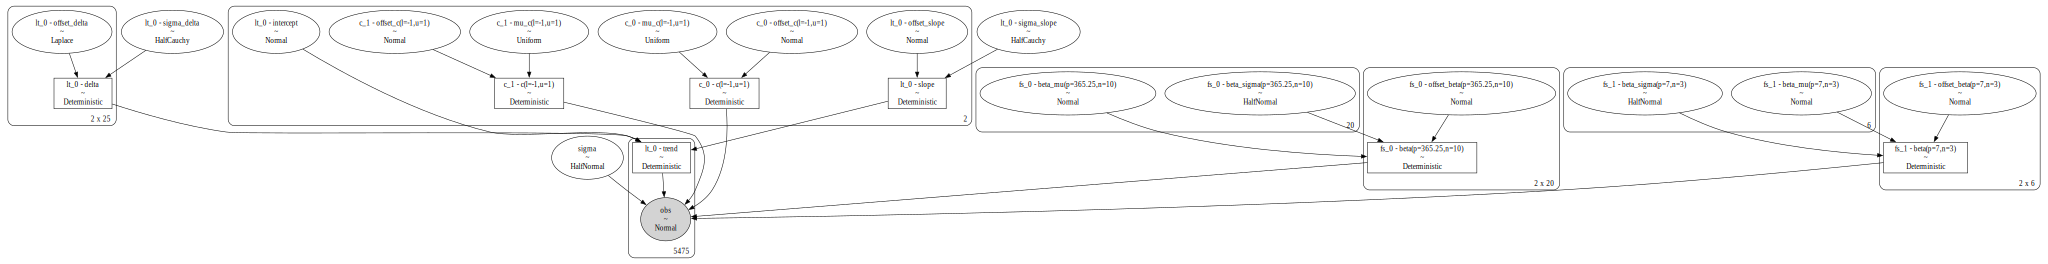

In [126]:
pm.model_to_graphviz(model.model)

In [ ]:
pm.plot_trace(model.trace)

In [20]:
yhat

,ds,t,lt_0_0,lt_0_1,lt_0_2,lt_0_3,c_0_0,c_0_1,c_0_2,c_0_3,...,fs_0_2,fs_0_3,fs_1_0,fs_1_1,fs_1_2,fs_1_3,yhat_0,yhat_1,yhat_2,yhat_3
0,2005-01-03,0.000000,0.160499,0.234425,0.719771,0.768382,-0.02735,-0.026878,-0.019597,-0.010322,...,-3.472547,-0.960211,-0.001130,-0.001178,-0.000752,-0.000108,0.167990,0.253669,0.754106,0.767984
1,2005-01-04,0.000548,0.160895,0.235318,0.719752,0.768476,-0.02735,-0.026878,-0.019597,-0.010322,...,-3.382518,-0.837598,-0.000380,-0.001145,-0.000645,-0.000152,0.168144,0.254780,0.752893,0.767071
2,2005-01-05,0.001096,0.161291,0.236211,0.719733,0.768571,-0.02735,-0.026878,-0.019597,-0.010322,...,-3.291716,-0.707396,0.000842,0.000345,0.000358,0.000312,0.168245,0.256146,0.752315,0.766489
3,2005-01-06,0.001645,0.161687,0.237104,0.719714,0.768665,-0.02735,-0.026878,-0.019597,-0.010322,...,-3.200671,-0.569815,0.001341,0.000357,0.000725,0.000171,0.168093,0.257056,0.751274,0.765383
4,2005-01-07,0.002193,0.162082,0.237997,0.719695,0.768760,-0.02735,-0.026878,-0.019597,-0.010322,...,-3.109797,-0.425191,0.000239,0.001417,0.000528,-0.000034,0.167536,0.258092,0.749831,0.764172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2185,2010-12-28,1.197917,1.468807,1.149067,1.041685,0.849359,-0.02735,-0.026878,-0.019597,-0.010322,...,-3.987408,-1.571319,-0.000380,-0.001145,-0.000645,-0.000152,1.540248,1.234348,1.101997,0.854239
2186,2010-12-29,1.198465,1.470238,1.150080,1.042428,0.849780,-0.02735,-0.026878,-0.019597,-0.010322,...,-3.921307,-1.497885,0.000842,0.000345,0.000358,0.000312,1.544881,1.238564,1.102478,0.854412
2187,2010-12-30,1.199013,1.471669,1.151092,1.043170,0.850200,-0.02735,-0.026878,-0.019597,-0.010322,...,-3.849053,-1.417088,0.001341,0.000357,0.000725,0.000171,1.548065,1.241201,1.102169,0.854006
2188,2010-12-31,1.199561,1.473100,1.152105,1.043912,0.850621,-0.02735,-0.026878,-0.019597,-0.010322,...,-3.771589,-1.328855,0.000239,0.001417,0.000528,-0.000034,1.548372,1.245088,1.101163,0.853479


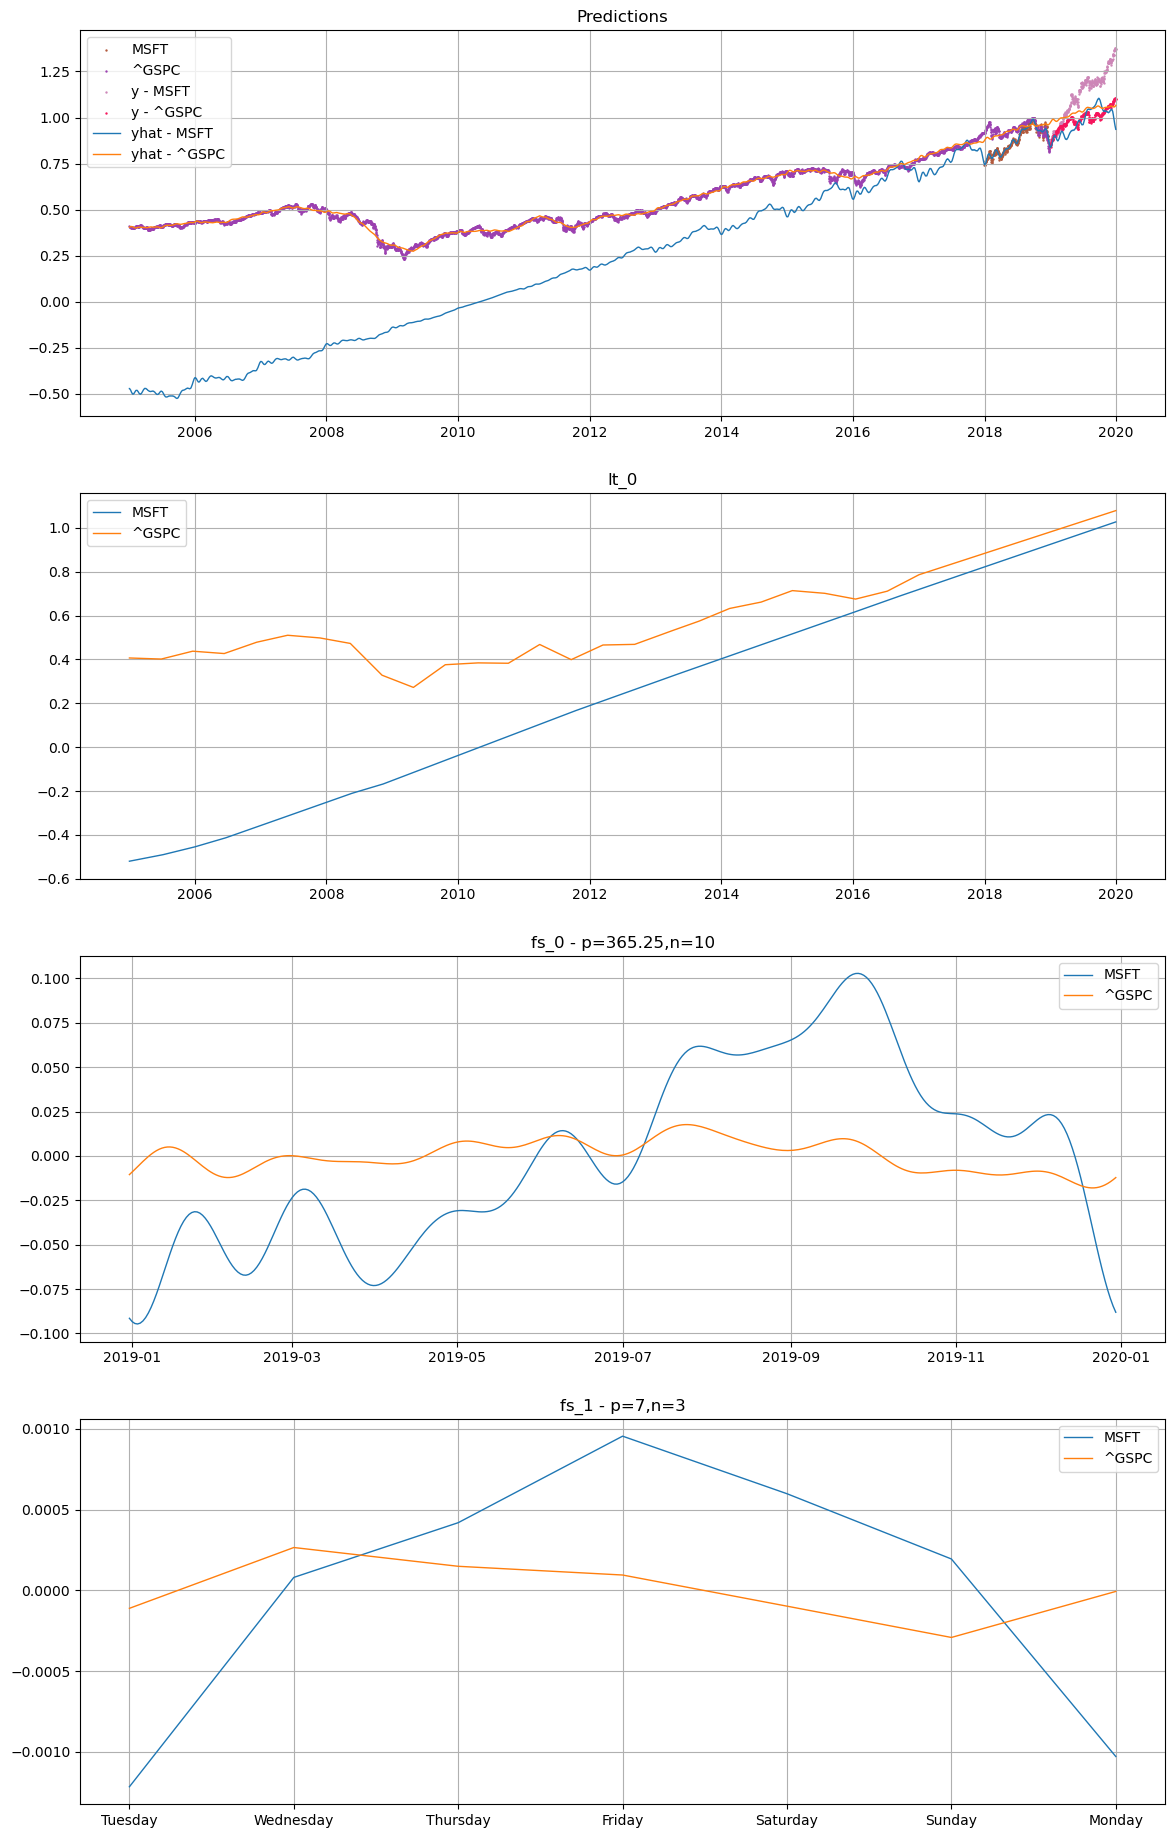

In [69]:
model.plot(yhat, y_true=test_df, pool_cols="series")

In [149]:
train_df_prophet, test_df_prophet, scales_prophet = generate_train_test_df(
    start=365 * 17, window=365 * 1, horizon=365, dfs=[dfs[1]], for_prophet=True
)     
train_df_prophet[0]

,open,high,low,close,typical_price,ds,series,y
6205,62.860001,63.200001,62.730000,57.004635,62.922501,2016-12-29,MSFT,0.724851
6206,62.959999,62.990002,62.029999,56.315849,62.530000,2016-12-30,MSFT,0.720329
6207,62.917500,62.952501,62.054999,56.415540,62.543750,2016-12-31,MSFT,0.720488
6208,62.875000,62.915001,62.080000,56.515230,62.557500,2017-01-01,MSFT,0.720646
6209,62.832500,62.877501,62.105000,56.614921,62.571251,2017-01-02,MSFT,0.720805
...,...,...,...,...,...,...,...,...
6565,85.355000,85.579998,84.974998,79.174889,85.341249,2017-12-24,MSFT,0.983109
6566,85.332499,85.554998,85.002499,79.149410,85.329374,2017-12-25,MSFT,0.982972
6567,85.309998,85.529999,85.029999,79.123932,85.317499,2017-12-26,MSFT,0.982836
6568,85.650002,85.980003,85.220001,79.411156,85.640001,2017-12-27,MSFT,0.986551


In [150]:
test_df_prophet[0]

,open,high,low,close,typical_price,ds,series,y
6570,85.629997,86.050003,85.500000,79.253632,85.680000,2017-12-29,MSFT,0.987011
6571,85.754997,86.115002,85.500000,79.348597,85.753125,2017-12-30,MSFT,0.987854
6572,85.879997,86.180000,85.500000,79.443562,85.826249,2017-12-31,MSFT,0.988696
6573,86.004997,86.244999,85.500000,79.538527,85.899374,2018-01-01,MSFT,0.989539
6574,86.129997,86.309998,85.500000,79.633492,85.972498,2018-01-02,MSFT,0.990381
...,...,...,...,...,...,...,...,...
6930,97.680000,97.970001,93.980003,88.722130,95.940001,2018-12-24,MSFT,1.105204
6931,96.410000,99.330002,93.970001,91.752422,96.763750,2018-12-25,MSFT,1.114693
6932,95.139999,100.690002,93.959999,94.782715,97.587500,2018-12-26,MSFT,1.124183
6933,99.300003,101.190002,96.400002,95.367104,99.517502,2018-12-27,MSFT,1.146416


In [151]:
for df, df_test in zip(train_df_prophet, test_df_prophet):
    prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, seasonality_mode="multiplicative")
    prophet.fit(df)
    future = prophet.make_future_dataframe(periods=365, include_history=True)
    forecast = prophet.predict(future)
    print(f"{df["series"].iloc[0]}-mape: {mean_absolute_percentage_error(df_test["y"], forecast[-365:]["yhat"])}")

MSFT-mape: 0.0745189584642531


In [155]:
model.metrics(test_df, yhat, pool_cols="series")

,MSFT,^GSPC
mse,0.007896,0.005306
rmse,0.088861,0.072839
mae,0.070190,0.065109
mape,0.058412,0.063201


In [32]:
model.metrics(test_df, yhat, pool_cols="series")

,AAPL,GOOG,MSFT,^GSPC
mse,0.011140,0.075678,0.070990,0.009771
rmse,0.105548,0.275096,0.266439,0.098848
mae,0.079413,0.240296,0.217516,0.083693
mape,0.070535,0.336585,0.312407,0.115353
